# Computer Assignment 6 (Neural Networks)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math

from abc import ABC, abstractmethod
from dataclasses import dataclass
from enum import Enum
from typing import Union, Iterable, Callable
from collections import namedtuple

In [2]:
DATA_DIR = 'data/'

TRAIN_IMAGES = DATA_DIR + 'TrainImgs.csv'
TRAIN_LABELS = DATA_DIR + 'TrainLabels.csv'
TEST_IMAGES  = DATA_DIR + 'TestImgs.csv'
TEST_LABELS  = DATA_DIR + 'TestLabels.csv'

CLASS_COUNT = 28
REMOVABLE_CLASSES = list(range(16, 28))

In [3]:
Image = namedtuple('Image', ['pixels', 'label'])

## Part 1: Data Analysis and Preprocessing

In [4]:
class DataLoader:

    def __init__(self, data: pd.DataFrame, labels: pd.DataFrame, n_classes: int, batch_size: Union[int, None] = None, shuffle: bool = False):
        assert len(data) == len(labels), 'Data and labels must have the same length'
        self._data: pd.DataFrame = data.copy()
        self._n_classes: int = n_classes
        self._batch_size: Union[int, None] = batch_size
        self._shuffle: bool = shuffle
        self._labels: pd.DataFrame = self._one_hot_encode(labels.copy(), n_classes)

    def _one_hot_encode(self, labels: pd.DataFrame, n_classes: int) -> pd.DataFrame:
        shape = (len(labels), n_classes)
        one_hot = np.zeros(shape)
        one_hot[np.arange(len(labels)), labels.values[:, 0] - 1] = 1
        return pd.DataFrame(one_hot)

    def _shuffle_data(self) -> None:
        data = pd.concat([self._data, self._labels], axis=1)
        data = data.sample(frac=1).reset_index(drop=True)
        self._data = data.iloc[:, :-self._n_classes]
        self._labels = data.iloc[:, -self._n_classes:]

    def __iter__(self) -> Iterable[tuple[np.ndarray, np.ndarray]]:
        if self._shuffle:
            self._shuffle_data()
            
        if self._batch_size == None:
            yield (self._data.values, self._labels.values)
            return
            
        for idx in range(0, len(self._data), self._batch_size):
            yield (self._data[idx:idx+self._batch_size].values,
                   self._labels[idx:idx+self._batch_size].values)
            
    def drop_classes(self, classes: list[int]) -> None:
        assert all([c in range(self._n_classes) for c in classes]), 'Classes must be in range [0, n_classes)'
        self._labels = self._labels.drop(columns=classes)
        self._labels = self._labels.loc[(self._labels != 0).any(axis=1)]
        self._data = self._data.loc[self._labels.index]
        self._data = self._data.reset_index(drop=True)
        self._labels = self._labels.reset_index(drop=True)
        self._n_classes = self._labels.shape[1]

    def scale(self, scale: Callable[[pd.Series], pd.Series]) -> None:
        self._data = self._data.apply(scale, axis=1)

    def get_class_images(self, class_idx: int) -> pd.DataFrame:
        assert class_idx in range(self._n_classes), 'Class index must be in range [0, n_classes)'
        return self._data[self._labels[class_idx] == 1]
    
    def get_labels(self) -> pd.DataFrame:
        return pd.DataFrame(np.argmax(self._labels.values, axis=1) + 1)

In [5]:
train_images = pd.read_csv(TRAIN_IMAGES, header=None)
train_labels = pd.read_csv(TRAIN_LABELS, header=None)
train_data = DataLoader(train_images, train_labels, CLASS_COUNT, shuffle=True)

test_images = pd.read_csv(TEST_IMAGES, header=None)
test_labels = pd.read_csv(TEST_LABELS, header=None)
test_data = DataLoader(test_images, test_labels, CLASS_COUNT, shuffle=True)

### 1.1 Plot a Sample of Each Class

In [6]:
def plot_images(images: list[Image], n_cols: int = 5) -> None:
    n_rows = math.ceil(len(images) / n_cols)
    _, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*2, n_rows*2))
    for i, img in enumerate(images):
        ax = axs[i // n_cols, i % n_cols] # type: ignore
        ax.imshow(img.pixels, cmap='gray')
        ax.set_title(img.label)
        ax.axis('off')
    plt.show()

There are 28 letters in the arabic alphabet. Each letter has a corresponding number from 1 to 28. The following code plots a random sample of each class.

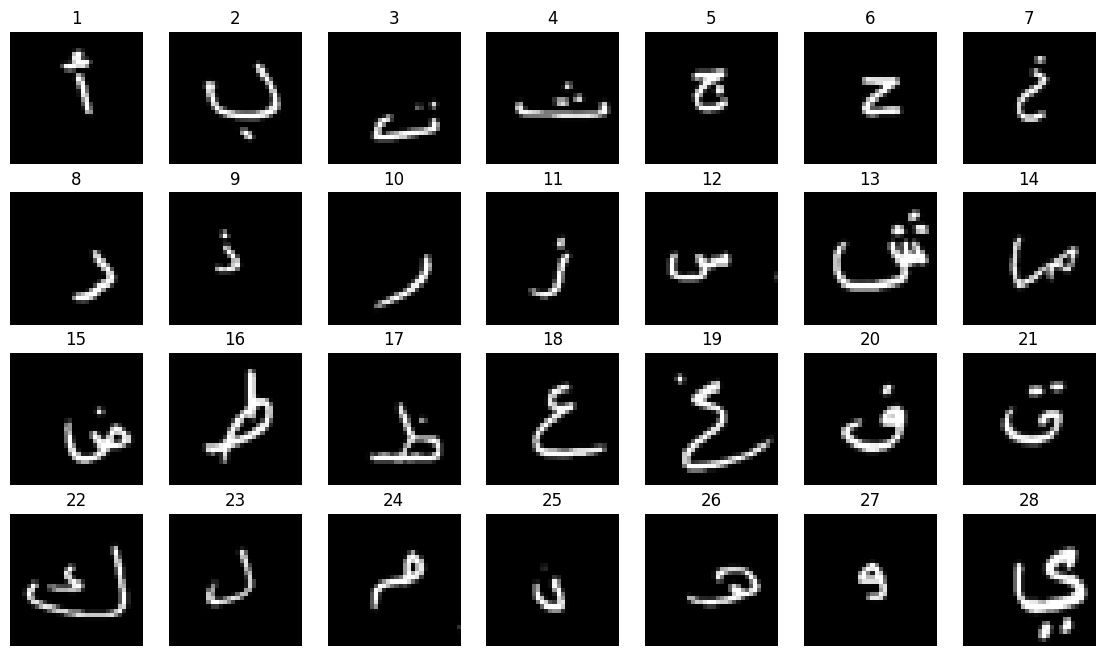

In [7]:
imgs = []
for label in range(CLASS_COUNT):
    img = train_data.get_class_images(label).sample(n=1).values[0].reshape(32, 32)
    img = np.transpose(img)
    imgs.append(Image(img, label + 1))
plot_images(imgs, 7)

### 1.2 Pixels Range

All the pixels in the dataset are in the range [0, 255]. The following code finds the minimum and maximum values of the pixels.

In [8]:
minimum = train_images.min().min()
maximum = train_images.max().max()
print(f'Minimum: {minimum}, Maximum: {maximum}')

Minimum: 0, Maximum: 255


### 1.3 Number of Classes and Samples

In [9]:
class_count = train_labels[0].nunique()
samples_count = train_labels[0].count()
print(f'Number of classes: {class_count}, Number of samples: {samples_count}')

Number of classes: 28, Number of samples: 13440


### 1.4 Using the First 16 Classes

I will use the first 16 classes and the rest of them will be ignored.

In [10]:
train_data.drop_classes(REMOVABLE_CLASSES)
test_data.drop_classes(REMOVABLE_CLASSES)

### 1.5 Number of Samples per Class

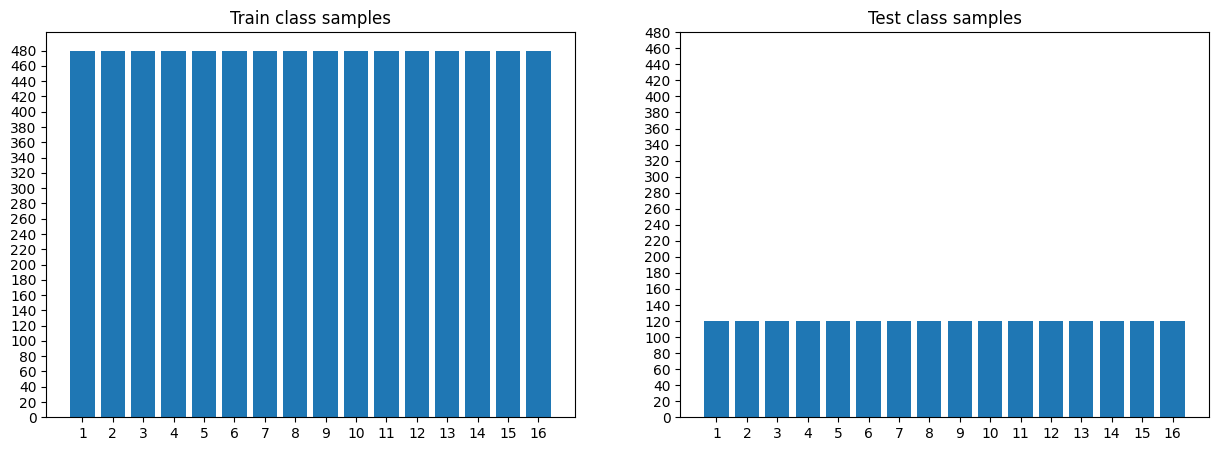

In [11]:
train_lbl = train_data.get_labels()
test_lbl = test_data.get_labels()

train_class_samples = train_lbl[0].value_counts().sort_index()
test_class_samples = test_lbl[0].value_counts().sort_index()

_, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].bar(train_class_samples.index, train_class_samples.values) # type: ignore
axs[0].set_title('Train class samples')
axs[0].set_xticks(range(1, 17))
axs[0].set_yticks(range(0, 500, 20))
axs[1].bar(test_class_samples.index, test_class_samples.values) # type: ignore
axs[1].set_title('Test class samples')
axs[1].set_xticks(range(1, 17))
axs[1].set_yticks(range(0, 500, 20))
plt.show()

As it can be seen from the previous plots, the number of samples per class are equal and the dataset is balanced. The training set has 16 classes and each class has 480 samples. The test set has 16 classes and each class has 120 samples.

### 1.6 Scaling the Data

In [12]:
train_data.scale(lambda x: (x - minimum) / (maximum - minimum)) # x /= 255
test_data.scale(lambda x: (x - minimum) / (maximum - minimum)) # x /= 255

The weights will be updated based on the difference between the predicted value and the actual value. If the values of the pixels are in the range [0, 255], the difference between the predicted value and the actual value will be in the range [0, 255]. This will cause the weights to be updated by a large amount, which will make the neural network **take a long time to converge**. To avoid this problem, we will scale (normalize) the data to be in the range [0, 1].

### 1.7 One-Hot Encoding

Labels are one-hot encoded inside the `DataLoader` class. If we don't use one-hot encoding, misclassification will be penalized more than it should be. For example, if the actual label is 1 and the predicted label is 2, the loss will be 1. If the actual label is 1 and the predicted label is 3, the loss will be 2. However, the difference between 1 and 2 is the same as the difference between 1 and 3. Therefore, we should use one-hot encoding to avoid this problem.  
As we are using one-hot encoding, the last layer of the neural network should have 16 neurons, one for each class. The index of the neuron with the highest value will be the predicted label.

## Part 2: Building the Neural Network

### Activation Functions

In [13]:
class ActivationFunction(ABC):

    def __init__(self):
        pass

    @abstractmethod
    def _val(self, matrix: np.ndarray) -> np.ndarray:
        pass

    def __call__(self, matrix: np.ndarray) -> np.ndarray:
        return self._val(matrix)
    
    @abstractmethod
    def derivative(self, matrix: np.ndarray) -> np.ndarray:
        pass

Now we define the following activation functions:

- Identical
- ReLU
- Leaky ReLU
- Sigmoid
- Softmax
- Tanh

#### Identical

This activation function is calculated as follows:

$$f(x) = x$$

The derivative of this activation function is calculated as follows:

$$f'(x) = 1$$

In [14]:
class Identical(ActivationFunction):

    def __init__(self):
        super().__init__()

    def _val(self, matrix: np.ndarray) -> np.ndarray:
        identical_value = np.copy(matrix).astype(np.float64)
        return identical_value

    def derivative(self, matrix: np.ndarray) -> np.ndarray:
        identical_derivative = np.ones(matrix.shape).astype(np.float64)
        return identical_derivative

#### ReLU

This activation function is calculated as follows:

$$f(x) = \max(0,\ x)$$

The derivative of this activation function is calculated as follows:

$$f'(x) = \begin{cases} 0 & x < 0 \\ 1 & x \geq 0 \end{cases}$$

In [15]:
class ReLU(ActivationFunction):

    def __init__(self):
        super().__init__()

    def _val(self, matrix: np.ndarray) -> np.ndarray:
        relu_value = np.copy(matrix).astype(np.float64)
        relu_value[relu_value < 0] = 0
        return relu_value

    def derivative(self, matrix: np.ndarray) -> np.ndarray:
        relu_derivative = np.copy(matrix).astype(np.float64)
        relu_derivative[relu_derivative < 0] = 0
        relu_derivative[relu_derivative > 0] = 1
        return relu_derivative

#### Leaky ReLU

This activation function is calculated as follows:

$$f(x) = \begin{cases} \alpha x & x < 0 \\ x & x \geq 0 \end{cases}$$

The derivative of this activation function is calculated as follows:

$$f'(x) = \begin{cases} \alpha & x < 0 \\ 1 & x \geq 0 \end{cases}$$

The special case of `LeakyReLU` with $\alpha = 0$ is `ReLU`.

In [16]:
class LeakyReLU(ActivationFunction):

    def __init__(self, negative_slope: float = 0.01):
        super().__init__()
        self._negative_slope: float = negative_slope

    def _val(self, matrix: np.ndarray) -> np.ndarray:
        leaky_relu_value = np.copy(matrix).astype(np.float64)
        leaky_relu_value = np.where(leaky_relu_value > 0, leaky_relu_value, leaky_relu_value * self._negative_slope)
        return leaky_relu_value
    
    def derivative(self, matrix: np.ndarray) -> np.ndarray:
        leaky_relu_derivative = np.copy(matrix).astype(np.float64)
        leaky_relu_derivative[leaky_relu_derivative > 0] = 1
        leaky_relu_derivative[leaky_relu_derivative < 0] = self._negative_slope
        return leaky_relu_derivative

#### Sigmoid

This activation function is calculated as follows:

$$f(x) = \frac{1}{1 + e^{-x}}$$

The derivative of this activation function is calculated as follows:

$$f'(x) = f(x) \cdot (1 - f(x)) = \frac{e^{-x}}{(1 + e^{-x})^2}$$

In [17]:
class Sigmoid(ActivationFunction):

    def __init__(self):
        super().__init__()

    def _val(self, matrix: np.ndarray) -> np.ndarray:
        sigmoid_value = np.copy(matrix).astype(np.float64)
        sigmoid_value = 1 / (1 + np.exp(-sigmoid_value))
        return sigmoid_value
    
    def derivative(self, matrix: np.ndarray) -> np.ndarray:
        sigmoid_derivative = self._val(matrix)
        sigmoid_derivative = sigmoid_derivative * (1 - sigmoid_derivative)
        return sigmoid_derivative

#### Softmax

This activation function is calculated as follows:

$$f(x) = \frac{e^{x_i}}{\sum_{j=1}^n e^{x_j}}$$

The derivative of this activation function is not implemented because it is not needed in this assignment.

In [18]:
class Softmax(ActivationFunction):

    def __init__(self):
        super().__init__()

    def _val(self, matrix: np.ndarray) -> np.ndarray:
        softmax_value = np.copy(matrix).astype(np.float64)
        softmax_value = np.exp(softmax_value)
        softmax_value = softmax_value / np.sum(softmax_value, axis=1, keepdims=True)
        return softmax_value

    def derivative(self, matrix: np.ndarray) -> np.ndarray:
        raise NotImplementedError('Softmax derivative is not implemented')

#### Tanh

This activation function is calculated as follows:

$$f(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$$

The derivative of this activation function is calculated as follows:

$$f'(x) = 1 - f^2(x) = 1 - \frac{(e^x - e^{-x})^2}{(e^x + e^{-x})^2}$$

In [19]:
class Tanh(ActivationFunction):

    def __init__(self):
        super().__init__()

    def _val(self, matrix: np.ndarray) -> np.ndarray:
        tanh_value = np.copy(matrix).astype(np.float64)
        tanh_value = np.tanh(tanh_value)
        return tanh_value

    def derivative(self, matrix: np.ndarray) -> np.ndarray:
        tanh_derivative = self._val(matrix)
        tanh_derivative = (1 - tanh_derivative) * (1 + tanh_derivative)
        return tanh_derivative

### Loss Functions

In [20]:
class LossFunction(ABC):

    def __init__(self):
        pass

    @abstractmethod
    def _val(self, predicted_val: np.ndarray, expected_val: np.ndarray) -> np.ndarray:
        pass

    def __call__(self, predicted_val: np.ndarray, expected_val: np.ndarray) -> np.ndarray:
        assert predicted_val.shape == expected_val.shape, 'predicted_val and expected_val must have the same shape'
        return self._val(predicted_val, expected_val)
    
    @abstractmethod
    def derivative(self, predicted_val: np.ndarray, expected_val: np.ndarray) -> np.ndarray:
        pass

Now we define the following loss functions:

- Mean Squared Error
- Cross Entropy

#### Mean Squared Error

This loss function is calculated as follows:

$$L = \frac{1}{n} \sum_{i=1}^n (\hat{y}_i - y_i)^2$$

The derivative of this loss function is calculated as follows:

$$\frac{\partial L}{\partial \hat{y}_i} = \frac{2}{n} (\hat{y}_i - y_i)$$

Where $y_i$ is the expected value and $\hat{y}_i$ is the predicted value.

In [21]:
class MeanSquaredError(LossFunction):

    def __init__(self):
        super().__init__()

    def _val(self, predicted_val: np.ndarray, expected_val: np.ndarray) -> np.ndarray:
        mse_value = predicted_val - expected_val
        mse_value = np.square(mse_value)
        mse_value = mse_value.sum(axis=1) / predicted_val.shape[1]
        return mse_value

    def derivative(self, predicted_val: np.ndarray, expected_val: np.ndarray) -> np.ndarray:
        assert predicted_val.shape == expected_val.shape, 'predicted_val and expected_val must have the same shape'
        mse_derivative = predicted_val - expected_val
        mse_derivative = mse_derivative * 2 / predicted_val.shape[1]
        return mse_derivative

#### Cross Entropy

Here I use `Softmax` as the activation function of the output layer. This loss function is calculated as follows:

$$L = -\sum\limits_{i=1}^n y_i \log(softmax(\hat{y}_i))$$

The derivative of this loss function is calculated as follows:

$$\frac{\partial L}{\partial \hat{y}_i} = softmax(\hat{y}_i) - y_i$$

Where $y_i$ is the expected value and $\hat{y}_i$ is the predicted value.

In [22]:
class CrossEntropy(LossFunction):

    def __init__(self):
        super().__init__()
        self._softmax = Softmax()

    def _val(self, predicted_val: np.ndarray, expected_val: np.ndarray) -> np.ndarray:
        ce_value = np.copy(expected_val).astype(np.float64)
        ce_value = ce_value * np.log(self._softmax(predicted_val))
        ce_value = -ce_value.sum(axis=1, keepdims=True)
        return ce_value
    
    def derivative(self, predicted_val: np.ndarray, expected_val: np.ndarray) -> np.ndarray:
        ce_derivative = self._softmax(predicted_val) - expected_val
        return ce_derivative

### Layer

In [23]:
class WeightDist(Enum):
    
    NORMAL = 1
    UNIFORM = 2


@dataclass
class WeightInitializer:

    dist: WeightDist
    mean: float = 0.0
    std: float = 1.0
    low: float = -1.0
    high: float = 1.0

    def __call__(self, shape: tuple[int, int]) -> np.ndarray:
        if self.dist == WeightDist.NORMAL:
            return np.random.normal(self.mean, self.std, shape)
        elif self.dist == WeightDist.UNIFORM:
            return np.random.uniform(self.low, self.high, shape)
        else:
            raise ValueError('Invalid weight distribution')

In [24]:
class Layer:

    DEFAULT_LOW, DEFAULT_HIGH, DEFAULT_MEAN, DEFAULT_STD = 0, 0.05, 0., 1.

    def __init__(self, input_size: int, output_size: int, activation: ActivationFunction = Identical(), 
                 init_weight_dist: WeightDist = WeightDist.UNIFORM, **init_params):
        self._n_neurons: int = output_size
        self._activation: ActivationFunction = activation
        self._weights: np.ndarray = self._init_weights(input_size, output_size, init_weight_dist, **init_params)
        self._bias: np.ndarray = self._init_weights(1, output_size, init_weight_dist, **init_params)

        self._last_input: Union[np.ndarray, None] = None
        self._last_activation_input: Union[np.ndarray, None] = None
        self._last_activation_output: Union[np.ndarray, None] = None
        self._last_activation_derivative: Union[np.ndarray, None] = None

    def _init_weights(self, input_size: int, output_size: int, init_weight_dist: WeightDist, **init_params) -> np.ndarray:
        low  = init_params.get('low', self.DEFAULT_LOW)
        high = init_params.get('high', self.DEFAULT_HIGH)
        mean = init_params.get('mean', self.DEFAULT_MEAN)
        std  = init_params.get('std', self.DEFAULT_STD)
        initializer = WeightInitializer(dist=init_weight_dist, low=low, high=high, mean=mean, std=std)
        return initializer((input_size, output_size))
    
    def forward(self, layer_input: np.ndarray) -> np.ndarray:
        assert np.ndim(layer_input) == 2, 'layer_input must be a matrix'
        assert np.size(self._weights, 0) == np.size(layer_input, 1), 'layer_input must have the same number of columns as the number of rows in the weight matrix'
        
        self._last_input = layer_input
        self._last_activation_input = layer_input @ self._weights + self._bias
        self._last_activation_output = self._activation(self._last_activation_input)
        self._last_activation_derivative = self._activation.derivative(self._last_activation_input)
        return self._last_activation_output
    
    def update_weights(self, back_prop_tensor: np.ndarray, learning_rate: float) -> np.ndarray:
        assert np.ndim(back_prop_tensor) == 2, 'back_prop_tensor must be a matrix'
        assert np.size(back_prop_tensor, 0) == np.size(self._last_activation_derivative, 0), 'back_prop_tensor must have the same number of rows as the number of rows in the activation derivative matrix' # type: ignore
        assert np.size(back_prop_tensor, 1) == self._n_neurons, 'back_prop_tensor must have the same number of columns as the number of neurons in the layer'

        back_prop_tensor = np.copy(back_prop_tensor).astype(np.float64)
        dy = back_prop_tensor * self._last_activation_derivative # type: ignore
        dw = self._last_input.T @ dy # type: ignore
        db = np.ones((1, np.size(dy, 0))) @ dy

        back_prop_tensor = dy @ self._weights.T
        self._weights -= learning_rate * dw
        self._bias -= learning_rate * db
        return back_prop_tensor
    
    @property
    def weights(self) -> np.ndarray:
        return self._weights
    
    @property
    def bias(self) -> np.ndarray:
        return self._bias
    
    @property
    def n_neurons(self) -> int:
        return self._n_neurons
    
    @property
    def activation(self) -> ActivationFunction:
        return self._activation

### Feed Forward Neural Network

In [25]:
class FeedForwardNN:

    def __init__(self, input_size: int):
        self._input_size: int = input_size
        self._output_size: int = input_size

        self._layers: list[Layer] = []
        self._loss: LossFunction = CrossEntropy()
        self._learning_rate: float = 1e-3

    def add_layer(self, n_neurons: int, activation: ActivationFunction = Identical(), 
                  init_weight_dist: WeightDist = WeightDist.UNIFORM, **init_params):
        assert n_neurons > 0, 'n_neurons must be greater than 0'
        input_size = self._layers[-1].n_neurons if len(self._layers) > 0 else self._input_size
        self._layers.append(Layer(input_size, n_neurons, activation, init_weight_dist, **init_params))
        self.output_size = n_neurons

    def set_training_params(self, loss: LossFunction = CrossEntropy(), learning_rate: float = 1e-3):
        self._loss = loss
        self._learning_rate = learning_rate

    def forward(self, network_input: np.ndarray) -> np.ndarray:
        assert self._layers, 'Network must have at least one layer'
        network_input = np.copy(network_input).astype(np.float64)
        for layer in self._layers:
            network_input = layer.forward(network_input)
        return network_input
    
    def fit(self, epochs: int, train_data: DataLoader, test_data: Union[DataLoader, None] = None, print_results: bool = True):
        assert self._layers, 'Network must have at least one layer'
        
        log: dict[str, list[float]] = {'train_loss': [], 'test_loss': [], 'train_accuracy': [], 'test_accuracy': []}

        for epoch in range(epochs):
            if print_results:
                print(f'Epoch {epoch + 1}')
            
            average_accuracy, average_loss = self._train(train_data)
            log['train_loss'].append(average_loss)
            log['train_accuracy'].append(average_accuracy)
            if print_results:
                print(f'\tTrain: Average Accuracy: {average_accuracy:7.4f}%\tAverage Loss: {average_loss:7.4f}')
            
            if test_data is not None:
                average_accuracy, average_loss = self._test(test_data)
                log['test_loss'].append(average_loss)
                log['test_accuracy'].append(average_accuracy)
                if print_results:
                    print(f'\tTest:  Average Accuracy: {average_accuracy:7.4f}%\tAverage Loss: {average_loss:7.4f}')

        return log
    
    def _train(self, train_data: DataLoader) -> tuple[float, float]:
        batch_accuracies, batch_losses = [], []
        for x_train, y_train in train_data: # type: ignore
            batch_accuracy, batch_loss = self._train_on_batch(x_train, y_train)
            batch_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
        return float(np.mean(batch_accuracies)), float(np.mean(batch_losses))
    
    def _test(self, test_data: DataLoader) -> tuple[float, float]:
        batch_accuracies, batch_losses = [], []
        for x_test, y_test in test_data: # type: ignore
            batch_accuracy, batch_loss = self._test_on_batch(x_test, y_test)
            batch_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
        return float(np.mean(batch_accuracies)), float(np.mean(batch_losses))
    
    def _train_on_batch(self, x_train: np.ndarray, y_train: np.ndarray) -> tuple[float, float]:
        network_output = self.forward(x_train)
        batch_accuracy = self._compute_accuracy(network_output, y_train)
        batch_average_loss = np.mean(self._loss(network_output, y_train))
        self._update_weights(network_output, y_train)
        return batch_accuracy, float(batch_average_loss)
    
    def _test_on_batch(self, x_test: np.ndarray, y_test: np.ndarray) -> tuple[float, float]:
        network_output = self.forward(x_test)
        batch_accuracy = self._compute_accuracy(network_output, y_test)
        batch_average_loss = np.mean(self._loss(network_output, y_test))
        return batch_accuracy, float(batch_average_loss)
    
    def _get_labels(self, network_output: np.ndarray) -> np.ndarray:
        return np.argmax(network_output, axis=1)
    
    def _compute_accuracy(self, network_output: np.ndarray, expected_output: np.ndarray) -> float:
        return np.mean(self._get_labels(network_output) == self._get_labels(expected_output)) * 100
    
    def _update_weights(self, network_output: np.ndarray, expected_output: np.ndarray) -> None:
        back_prop_tensor = self._loss.derivative(network_output, expected_output)
        for layer in reversed(self._layers):
            back_prop_tensor = layer.update_weights(back_prop_tensor, self._learning_rate)

## Part 3: Data Classification

### 3.1 Training the Neural Network

#### 3.1.1 Training the Neural Network with the following parameters:

- Number of epochs: 100
- Learning rate: 0.005
- batch_size: 32
- Activation function: `ReLU` except for the output layer which uses `Identical`
- Initial weights distribution: `Normal` or `Uniform`

In [26]:
def get_train_and_test_data(batch_size: int) -> tuple[DataLoader, DataLoader]:
    train_data = DataLoader(train_images, train_labels, 28, batch_size=batch_size, shuffle=True)
    test_data = DataLoader(test_images, test_labels, 28, batch_size=batch_size, shuffle=True)
    train_data.drop_classes(REMOVABLE_CLASSES)
    test_data.drop_classes(REMOVABLE_CLASSES)
    train_data.scale(lambda x: x / 255)
    test_data.scale(lambda x: x / 255)
    return train_data, test_data

In [27]:
def plot_results(log: dict[str, list[float]]) -> None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(log['train_loss'], label='Train Loss')
    ax1.plot(log['test_loss'], label='Test Loss')
    ax1.set_title('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax2.plot(log['train_accuracy'], label='Train Accuracy')
    ax2.plot(log['test_accuracy'], label='Test Accuracy')
    ax2.set_title('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    plt.show()

In [28]:
INPUT_SIZE: int = 32 * 32
LEARNING_RATE: float = 0.005
EPOCHS: int = 100
TRAIN_LOADER, TEST_LOADER = get_train_and_test_data(32)

In [29]:
network = FeedForwardNN(INPUT_SIZE)
network.add_layer(10, activation=ReLU())
network.add_layer(10, activation=ReLU())
network.add_layer(16, activation=Identical())
network.set_training_params(learning_rate=LEARNING_RATE)

log = network.fit(EPOCHS, TRAIN_LOADER, TEST_LOADER)

Epoch 1
	Train: Average Accuracy:  9.5443%	Average Loss:  2.6461
	Test:  Average Accuracy: 13.8542%	Average Loss:  2.4977
Epoch 2
	Train: Average Accuracy: 13.3984%	Average Loss:  2.4379
	Test:  Average Accuracy: 12.0312%	Average Loss:  2.3871
Epoch 3
	Train: Average Accuracy: 15.0000%	Average Loss:  2.3451
	Test:  Average Accuracy: 16.1458%	Average Loss:  2.2834
Epoch 4
	Train: Average Accuracy: 23.1380%	Average Loss:  2.0655
	Test:  Average Accuracy: 26.6146%	Average Loss:  1.9420
Epoch 5
	Train: Average Accuracy: 29.3490%	Average Loss:  1.8752
	Test:  Average Accuracy: 30.1562%	Average Loss:  1.8038
Epoch 6
	Train: Average Accuracy: 33.9453%	Average Loss:  1.7092
	Test:  Average Accuracy: 34.0625%	Average Loss:  1.6507
Epoch 7
	Train: Average Accuracy: 36.0286%	Average Loss:  1.6008
	Test:  Average Accuracy: 36.7188%	Average Loss:  1.5676
Epoch 8
	Train: Average Accuracy: 40.1693%	Average Loss:  1.4887
	Test:  Average Accuracy: 41.4062%	Average Loss:  1.4853
Epoch 9
	Train: Average 

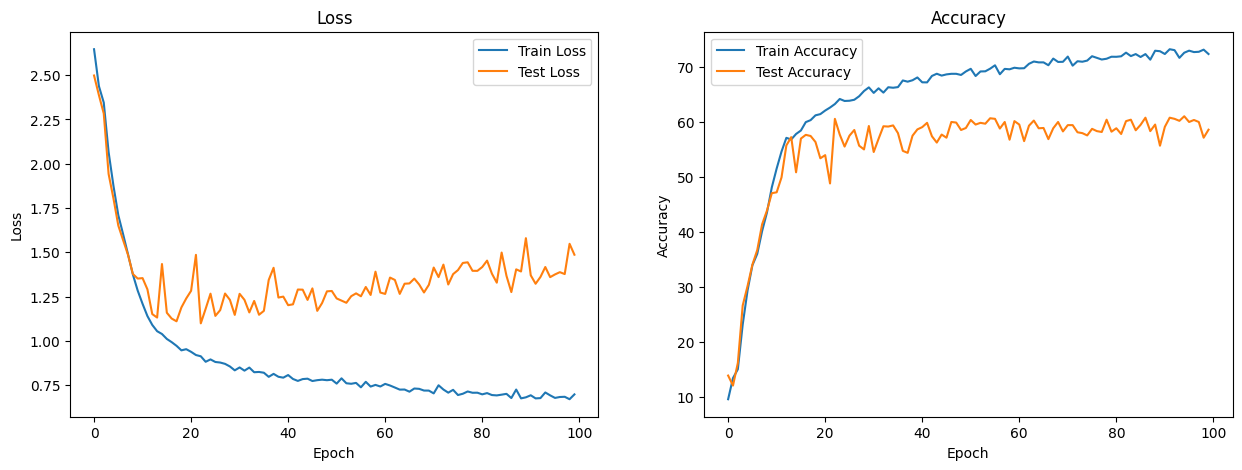

In [30]:
plot_results(log)

#### 3.1.2 Increasing the Accuracy

Adding more layers and increasing the number of neurons in each layer will increase the accuracy. However, this will increase the training time.

In [31]:
network = FeedForwardNN(INPUT_SIZE)
network.add_layer(35, activation=ReLU())
network.add_layer(35, activation=ReLU())
network.add_layer(35, activation=ReLU())
network.add_layer(16, activation=Identical())
network.set_training_params(learning_rate=LEARNING_RATE)

log = network.fit(EPOCHS, TRAIN_LOADER, TEST_LOADER)

Epoch 1
	Train: Average Accuracy:  9.2969%	Average Loss:  2.6508
	Test:  Average Accuracy: 13.5938%	Average Loss:  2.5104
Epoch 2
	Train: Average Accuracy: 12.7083%	Average Loss:  2.4652
	Test:  Average Accuracy: 13.8542%	Average Loss:  2.3838
Epoch 3
	Train: Average Accuracy: 14.3750%	Average Loss:  2.3755
	Test:  Average Accuracy: 15.3125%	Average Loss:  2.3289
Epoch 4
	Train: Average Accuracy: 15.5469%	Average Loss:  2.3392
	Test:  Average Accuracy: 15.8333%	Average Loss:  2.2958
Epoch 5
	Train: Average Accuracy: 17.0312%	Average Loss:  2.2918
	Test:  Average Accuracy: 19.3750%	Average Loss:  2.1528
Epoch 6
	Train: Average Accuracy: 22.2266%	Average Loss:  2.0542
	Test:  Average Accuracy: 24.8958%	Average Loss:  1.9429
Epoch 7
	Train: Average Accuracy: 26.4453%	Average Loss:  1.9713
	Test:  Average Accuracy: 28.8542%	Average Loss:  1.8838
Epoch 8
	Train: Average Accuracy: 28.6458%	Average Loss:  1.9106
	Test:  Average Accuracy: 31.0417%	Average Loss:  1.8184
Epoch 9
	Train: Average 

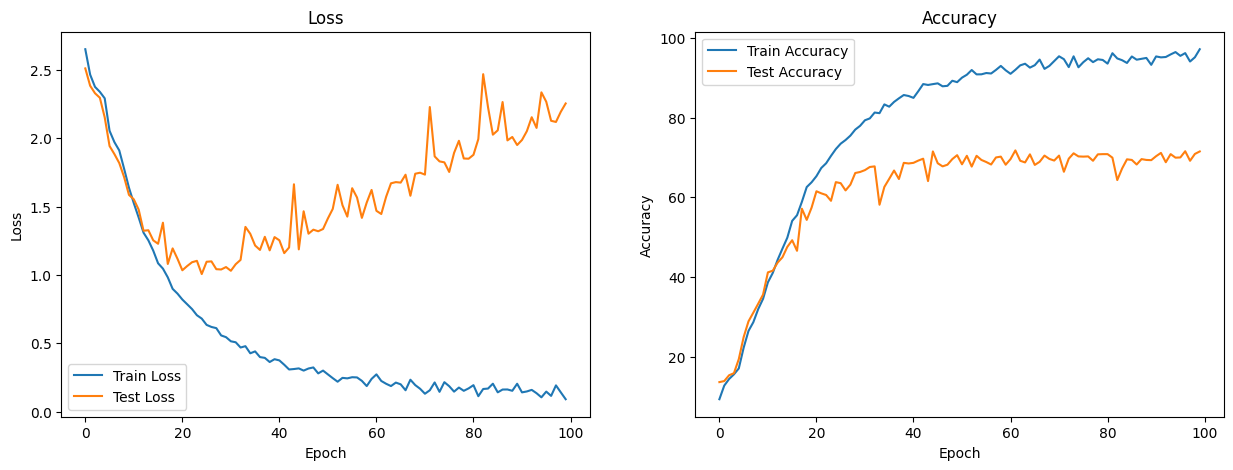

In [32]:
plot_results(log)

As it is shown above, the training accuracy is 97% and the test accuracy is 71%.

In [38]:
network = FeedForwardNN(INPUT_SIZE)
network.add_layer(70, activation=ReLU())
network.add_layer(16, activation=Identical())
network.set_training_params(learning_rate=LEARNING_RATE)

log = network.fit(EPOCHS, TRAIN_LOADER, TEST_LOADER)

Epoch 1
	Train: Average Accuracy: 21.9271%	Average Loss:  2.3571
	Test:  Average Accuracy: 36.3542%	Average Loss:  1.8112
Epoch 2
	Train: Average Accuracy: 42.6953%	Average Loss:  1.6821
	Test:  Average Accuracy: 45.6771%	Average Loss:  1.5363
Epoch 3
	Train: Average Accuracy: 50.9896%	Average Loss:  1.4071
	Test:  Average Accuracy: 53.9062%	Average Loss:  1.3095
Epoch 4
	Train: Average Accuracy: 57.6302%	Average Loss:  1.2002
	Test:  Average Accuracy: 57.8125%	Average Loss:  1.1634
Epoch 5
	Train: Average Accuracy: 62.0703%	Average Loss:  1.0540
	Test:  Average Accuracy: 60.2083%	Average Loss:  1.1005
Epoch 6
	Train: Average Accuracy: 65.5859%	Average Loss:  0.9446
	Test:  Average Accuracy: 62.5000%	Average Loss:  1.0253
Epoch 7
	Train: Average Accuracy: 68.5677%	Average Loss:  0.8576
	Test:  Average Accuracy: 63.9583%	Average Loss:  0.9597
Epoch 8
	Train: Average Accuracy: 71.5365%	Average Loss:  0.7782
	Test:  Average Accuracy: 67.2396%	Average Loss:  0.8991
Epoch 9
	Train: Average 

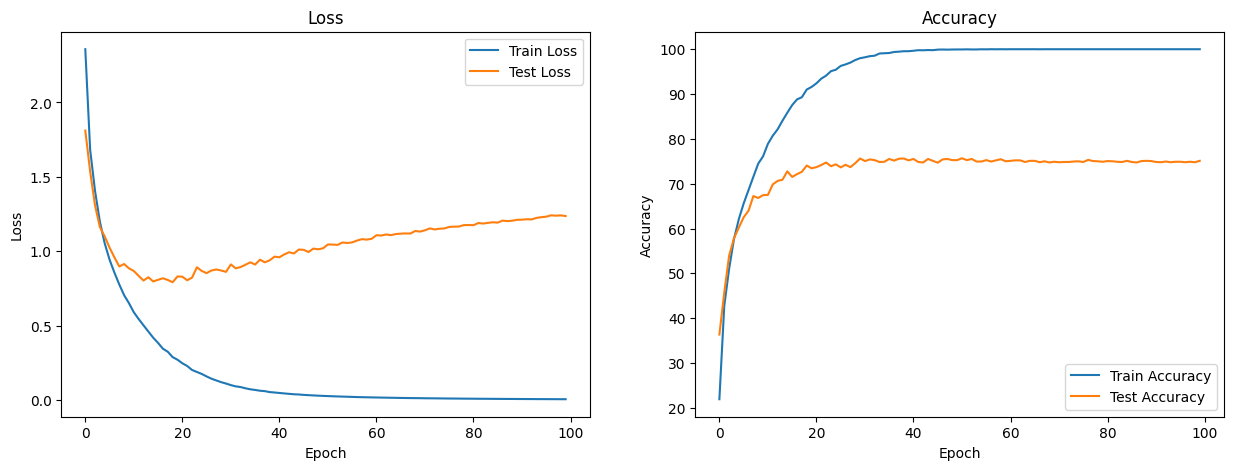

In [39]:
plot_results(log)

In this case, the training accuracy has reached 100% and the test accuracy is about 75%.

### 3.2 Network Weighting

#### 3.2.1 Initialization of weights with 0